In [1]:
%matplotlib inline
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pdb

In [2]:
# Define globals
### network name <=> data file mapping
_FILEMAP_={'vgg16a' : 'sp_vgg16a_iter_',
           'vgg16b' : 'sp_vgg16b_iter_',
           'vgg16c' : 'sp_vgg16c_iter_',
           'resnet14b'    : 'sp_resnet14b_iter_',
           #'resnet14b_w4' : 'sp_resnet14b_w4_iter_',
           'resnet29b'    : 'sp_resnet29b_iter_',
           #'resnet29b_w2' : 'sp_resnet29b_w2_iter_',
           'resnet29b_w4' : 'sp_resnet29b_w4_iter_',
           'resnet50b'    : 'sp_resnet50b_iter_',
           'plainresnet10b'    : 'sp_plainresnet10b_iter_'
           #'plainresnet10b_w4' : 'sp_plainresnet10b_w4_iter_',
           #'plainresnet12b'    : 'sp_plainresnet12b_iter_',
           #'plainresnet18b'    : 'sp_plainresnet18b_iter_',
           #'plainresnet18b_w4' : 'sp_plainresnet18b_w4_iter_',
           #'plainresnet20b'    : 'sp_plainresnet20b_iter_',
           #'plainresnet20b_w4' : 'sp_plainresnet20b_w4_iter_'
          }
_DATAMAP_={}
_FILEDIR_='testB'
_LABELS_=['eminus','gamma','muminus','piminus','proton']

In [3]:
class Analysis:
    """
        Class encapsulation of kinematics analysis routines
    """
    total_file_list = os.listdir(_FILEDIR_)
    labels_to_check=['energy_dep','energy_start','mass','mom_start','dcosx_start',
                     'dcosy_start','dcosz_start','nparticle','ndecay','npx']
    bins = [i*50.0 for i in range(40)]
    ctbins = [-1. + i*0.05 for i in range(40)]
    
    def __init__(self, netname):
        """
            A single instance corresponds to a single network
        """
        self.netname = netname
        self._iter_files=None
        self._iter_map ={}
        
    @property
    def best_weights(self):
        """
            Uses the results from the previous step to fetch out the iteration
            with the "best" weights. More accurately: weights with best efficiency.
        """
        previous_results = json.load(open('weights.json','r'))['results']
        for result in previous_results:
            if result['name'] == self.netname:
                return result['iter']
    @property
    def iter_files(self):
        """
            Gets a list of all files corresponding to this network
        """
        if self._iter_files is not None: return self._iter_files
        return [i for i in self.total_file_list if self.netname in i]
        
    @property
    def iter_map(self):
        """
            Returns a  map of iteration->iteration file
        """
        if len(self._iter_map)>0: return self._iter_map
        for i in self.iter_files:
            self._iter_map[int(i.strip('.csv').split("_")[-1])]= os.path.join(_FILEDIR_,i)
        return self._iter_map
    
    @property
    def iter_sorted(self):
        """
            Returns a sorted list of iterations
        """
        return [key for key in sorted(self.iter_map.iterkeys())]
    
    def df(self, iteration):
        """
            Get the dataframe for a specific iteration
        """
        return pd.read_csv(self.iter_map[iteration], error_bad_lines=False)
    
    def __repr__(self):
        return """
               Purity Analysis on Network: {}
               Iterations: {}
               """.format(self.netname, self.iter_sorted)

    def analyze(self):
        """
            For this network, return a graph of energy->efficiency
        """
        results={
            'name': self.netname,
            'energy2efficiency':[],
            'costhy2efficiency':[],
            'costhx2efficiency':[]
        }
        # Get the inference output for a particular weight file and 
        # bin by energy
        df = self.df(self.best_weights)
        centers = [i+25 for i in self.bins[:-1]]
        ctcenters = [i+0.05 for i in self.ctbins[:-1]]
        df['bin'] = pd.cut(df['energy_start'], self.bins, labels=centers)
        df['ctybin'] = pd.cut(df['dcosy_start'], self.ctbins, labels=ctcenters)
        df['ctxbin'] = pd.cut(df['dcosx_start'], self.ctbins, labels=ctcenters)

        # Now calculate the efficiency per bin and append to results
        for bin_label in centers:
            binned_df = df.query('bin=={}'.format(bin_label))
            if len(binned_df)==0: continue
            correct_values = binned_df.query('label==prediction')
            incorrect_values = binned_df.query('label!=prediction')
            efficiency = float(len(correct_values))/(len(correct_values)+len(incorrect_values))
            results['energy2efficiency'].append( (bin_label, efficiency,) ) 

        for bin_label in ctcenters:
            binned_ctydf = df.query('ctybin=={}'.format(bin_label))
            if len(binned_ctydf)==0: continue
            correct_ctyvalues = binned_ctydf.query('label==prediction')
            incorrect_ctyvalues = binned_ctydf.query('label!=prediction')
            efficiencycty = float(len(correct_ctyvalues))/(len(correct_ctyvalues)+len(incorrect_ctyvalues))
            results['costhy2efficiency'].append( (bin_label, efficiencycty,) ) 
            
            binned_ctxdf = df.query('ctxbin=={}'.format(bin_label))
            if len(binned_ctxdf)==0: continue
            correct_ctxvalues = binned_ctxdf.query('label==prediction')
            incorrect_ctxvalues = binned_ctxdf.query('label!=prediction')
            efficiencyctx = float(len(correct_ctxvalues))/(len(correct_ctxvalues)+len(incorrect_ctxvalues))
            results['costhx2efficiency'].append( (bin_label, efficiencyctx,) ) 
        return results

In [4]:
analyses = [Analysis(i) for i in _FILEMAP_ ]

In [5]:
[i.best_weights for i in analyses if len(i.iter_sorted)>0]
analysis_results = [i.analyze() for i in analyses if len(i.iter_sorted)>0]

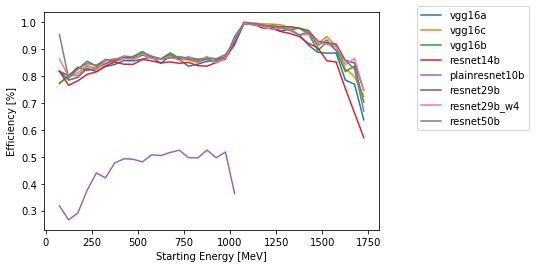

In [6]:
plt.figure()
for result in analysis_results:
    plt.plot([i[0] for i in result['energy2efficiency']],
             [i[1] for i in result['energy2efficiency']],
            label = result['name'])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Efficiency [%]")
plt.xlabel("Starting Energy [MeV]")
plt.show()

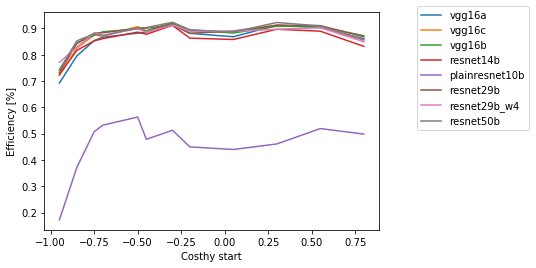

In [7]:
plt.figure()
for result in analysis_results:
    plt.plot([i[0] for i in result['costhy2efficiency']],
             [i[1] for i in result['costhy2efficiency']],
            label = result['name'])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Efficiency [%]")
plt.xlabel("Costhy start")
plt.show()

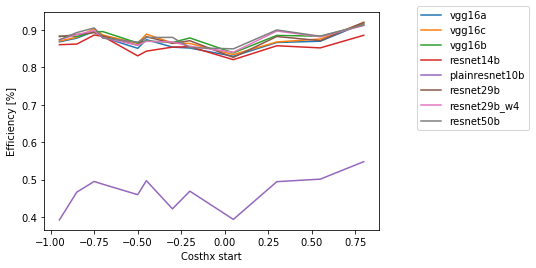

{'costhx2efficiency': [(-0.95, 0.8733766233766234), (-0.85, 0.8927813163481954), (-0.75, 0.9051633298208641), (-0.7, 0.8780207134637514), (-0.5, 0.8672985781990521), (-0.45, 0.8795454545454545), (-0.3, 0.879950495049505), (-0.2, 0.8525798525798526), (0.05, 0.8493150684931506), (0.3, 0.8997093023255814), (0.55, 0.882962962962963), (0.8, 0.9130434782608695)], 'costhy2efficiency': [(-0.95, 0.742320819112628), (-0.85, 0.8529411764705882), (-0.75, 0.8796791443850267), (-0.7, 0.8720626631853786), (-0.5, 0.9021164021164021), (-0.45, 0.9035532994923858), (-0.3, 0.923784494086728), (-0.2, 0.8948751642575559), (0.05, 0.8865979381443299), (0.3, 0.9227799227799228), (0.55, 0.9096945551128818), (0.8, 0.8573232323232324)], 'energy2efficiency': [(75.0, 0.9545454545454546), (125.0, 0.7919621749408984), (175.0, 0.8266494178525227), (225.0, 0.8468118195956454), (275.0, 0.8406317300789663), (325.0, 0.8617886178861789), (375.0, 0.8597122302158273), (425.0, 0.8747346072186837), (475.0, 0.8707671043538355),

In [8]:
plt.figure()
for result in analysis_results:
    plt.plot([i[0] for i in result['costhx2efficiency']],
             [i[1] for i in result['costhx2efficiency']],
            label = result['name'])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Efficiency [%]")
plt.xlabel("Costhx start")
plt.show()
print result